## サンプルごとの介入によるロスの差の統計的分析

現在の可視化に使ってる元のテーブルはすべてのサンプルのロスの平均．なので，サンプルごとのロスを保存するようにして，手法ごとにロスの差の検定を行う．

利用するサンプル数 N とすると，手法のペアごとに N サンプルの差の検定を 5 (tgt_rank) x 4 (misclf_type_name) 回する．

手法のペア数は？
- betaの数は4通り
- ours以外の比較はbl, random
- ペア数は全部で 8 通りでした．
- 統計的検定自体の数は 8 (ペア数) x 5 (tgt_rank) x 4 (misclf_type_name) = 160 回なので補正が必要ぽい．

In [4]:
import os, sys, time, pickle, json, math
from tqdm import tqdm
from collections import defaultdict
from itertools import product
import numpy as np
import pandas as pd
import torch
from utils.helper import get_device, json2dict
from utils.vit_util import identfy_tgt_misclf, localize_neurons_with_mean_activation, get_batched_hs, get_batched_labels, ViTFromLastLayer
from utils.constant import ViTExperiment, ExperimentRepair1, Experiment3, ExperimentRepair2
from utils.log import set_exp_logging
from logging import getLogger
from datasets import load_from_disk
from transformers import ViTForImageClassification
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
# Notebook向け
%matplotlib inline
from itertools import product
from scipy.stats import wilcoxon

device = get_device()

Device: cuda


In [7]:
# 比較対象とパラメータ
methods = ["ours", "bl", "random"]
beta_list = [0.1, 0.25, 0.5, 0.75, 1.0]
comparison_pairs = defaultdict(list)
for beta in beta_list:
    comparison_pairs[beta] = [(("ours", beta), "bl"), (("ours", beta), "random"), ("bl", "random")]
tgt_ranks = [1, 2, 3, 4, 5]
misclf_types = ["src_tgt", "tgt", "tgt_fp", "tgt_fn"]
sample_types = ["cor", "mis"]
pretrained_dir = ViTExperiment.c100.OUTPUT_DIR.format(k=0) # /src/out_vit_c100_fold0
n = ExperimentRepair2.NUM_IDENTIFIED_WEIGHTS
op_list = ["enhance", "suppress", "multiply-2"]


def get_loss_diff_path(n, beta, method, loss_diff_dir, op, cor_mis):
    assert cor_mis in ["cor", "mis"], f"Unknown cor_mis: {cor_mis}"
    if method == "ours":
        return os.path.join(loss_diff_dir, f"exp-fl-6_loss_diff_n{n}_beta{beta}_{op}_{cor_mis}_weight_ours.npy")
    elif method == "bl":
        return os.path.join(loss_diff_dir, f"exp-fl-2_loss_diff_n{n}_{op}_{cor_mis}_weight_bl.npy")
    elif method == "random":
        return os.path.join(loss_diff_dir, f"exp-fl-1_loss_diff_n{n}_{op}_{cor_mis}_weight_random.npy")
    else:
        raise ValueError(f"Unknown method: {method}")


def load_best_loss_diff(n, beta, method, tgt_rank, misclf_type, sample_type, ops=None):
    if ops is None:
        ops = ["enhance", "suppress"]
    loss_diff_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", f"{misclf_type}_weights_location", "loss_diff_per_sample")
    paths = {
        op: get_loss_diff_path(n, beta, method, loss_diff_dir, op, sample_type)
        for op in ops
    }
    # 存在チェック & 読み込み
    losses = {}
    for op, path in paths.items():
        if not os.path.exists(path):
            raise FileNotFoundError(f"'{op}' の loss_diff ファイルが見つかりません: {path}")
        losses[op] = np.load(path)
    # 形状チェック
    shapes = [arr.shape for arr in losses.values()]
    if not all(shape == shapes[0] for shape in shapes):
        raise AssertionError(f"Shape mismatch among operations: {dict(zip(ops, shapes))}")
    losses = {op: np.load(path) for op, path in paths.items() if os.path.exists(path)}
    # best
    # shape = (num_ops, ...) -> 各サンプルで最小値を取る
    stacked = np.stack(list(losses.values()), axis=0)
    best_losses = np.min(stacked, axis=0)

    return best_losses

def cliffs_delta_from_diff(diff):
    gt = np.sum(diff > 0)
    lt = np.sum(diff < 0)
    n = len(diff)
    return (gt - lt) / n

=== beta: 0.1 ===
Comparison pairs: [(('ours', 0.1), 'bl'), (('ours', 0.1), 'random'), ('bl', 'random')]


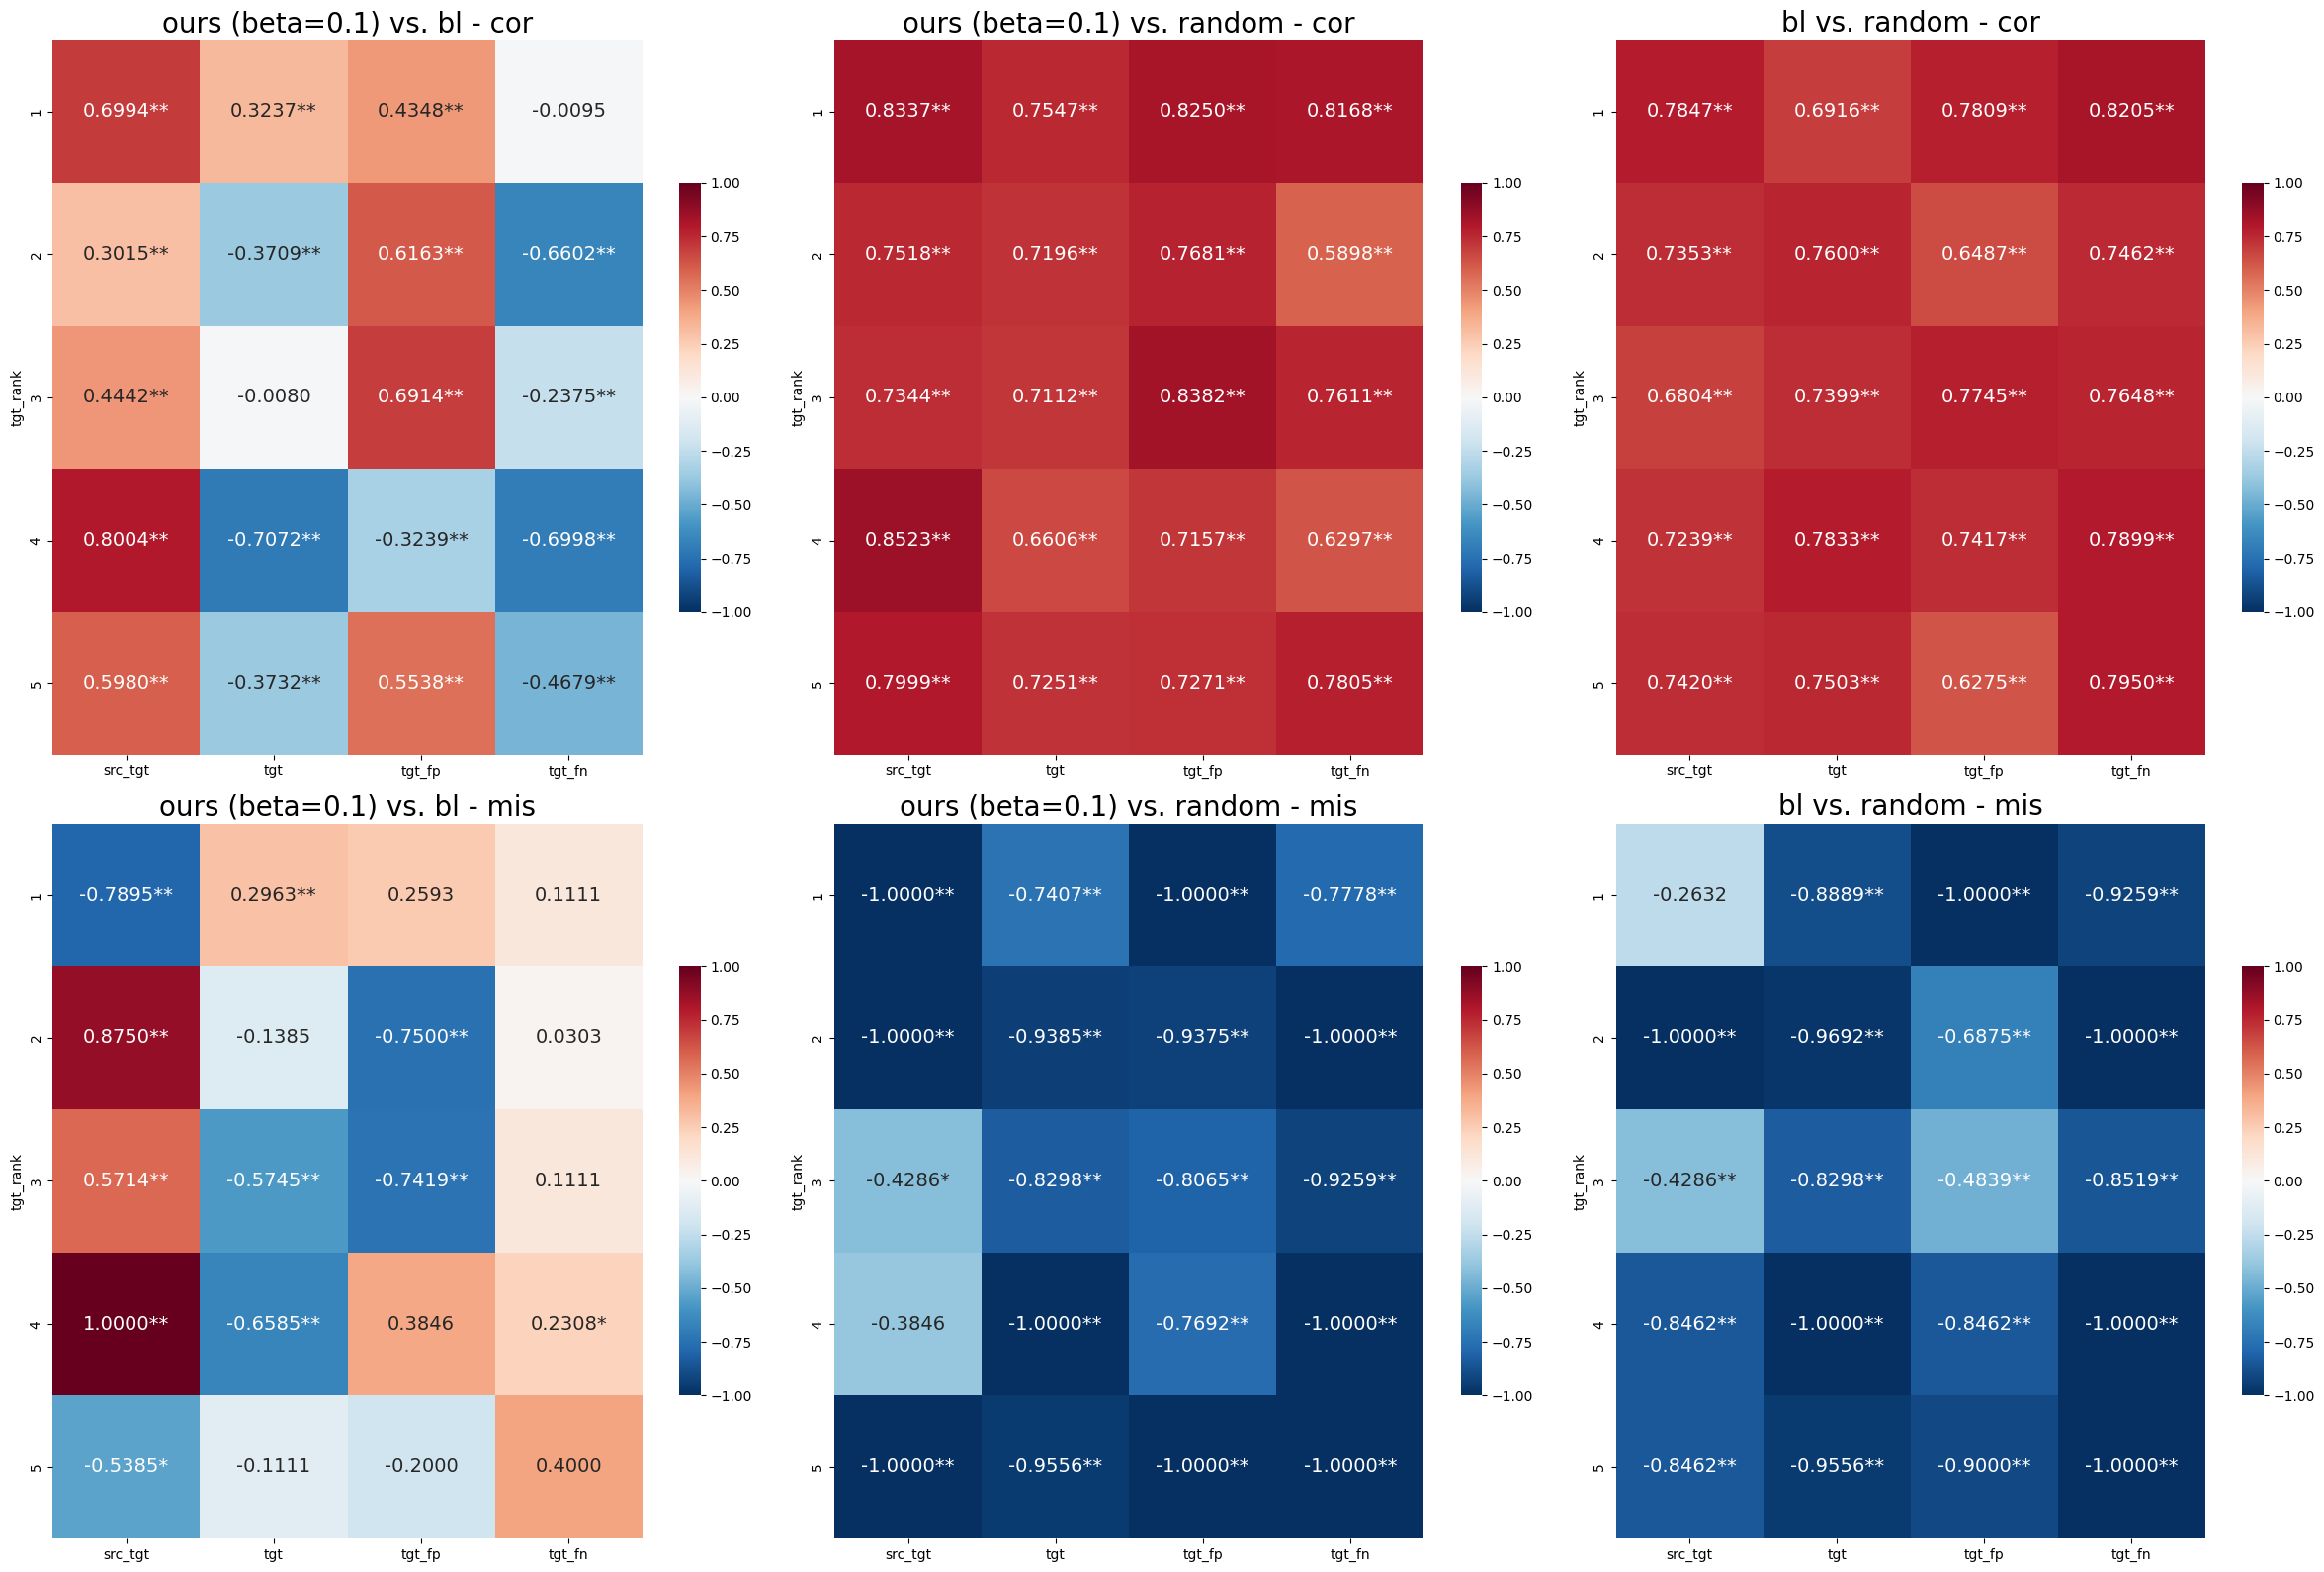

=== beta: 0.25 ===
Comparison pairs: [(('ours', 0.25), 'bl'), (('ours', 0.25), 'random'), ('bl', 'random')]


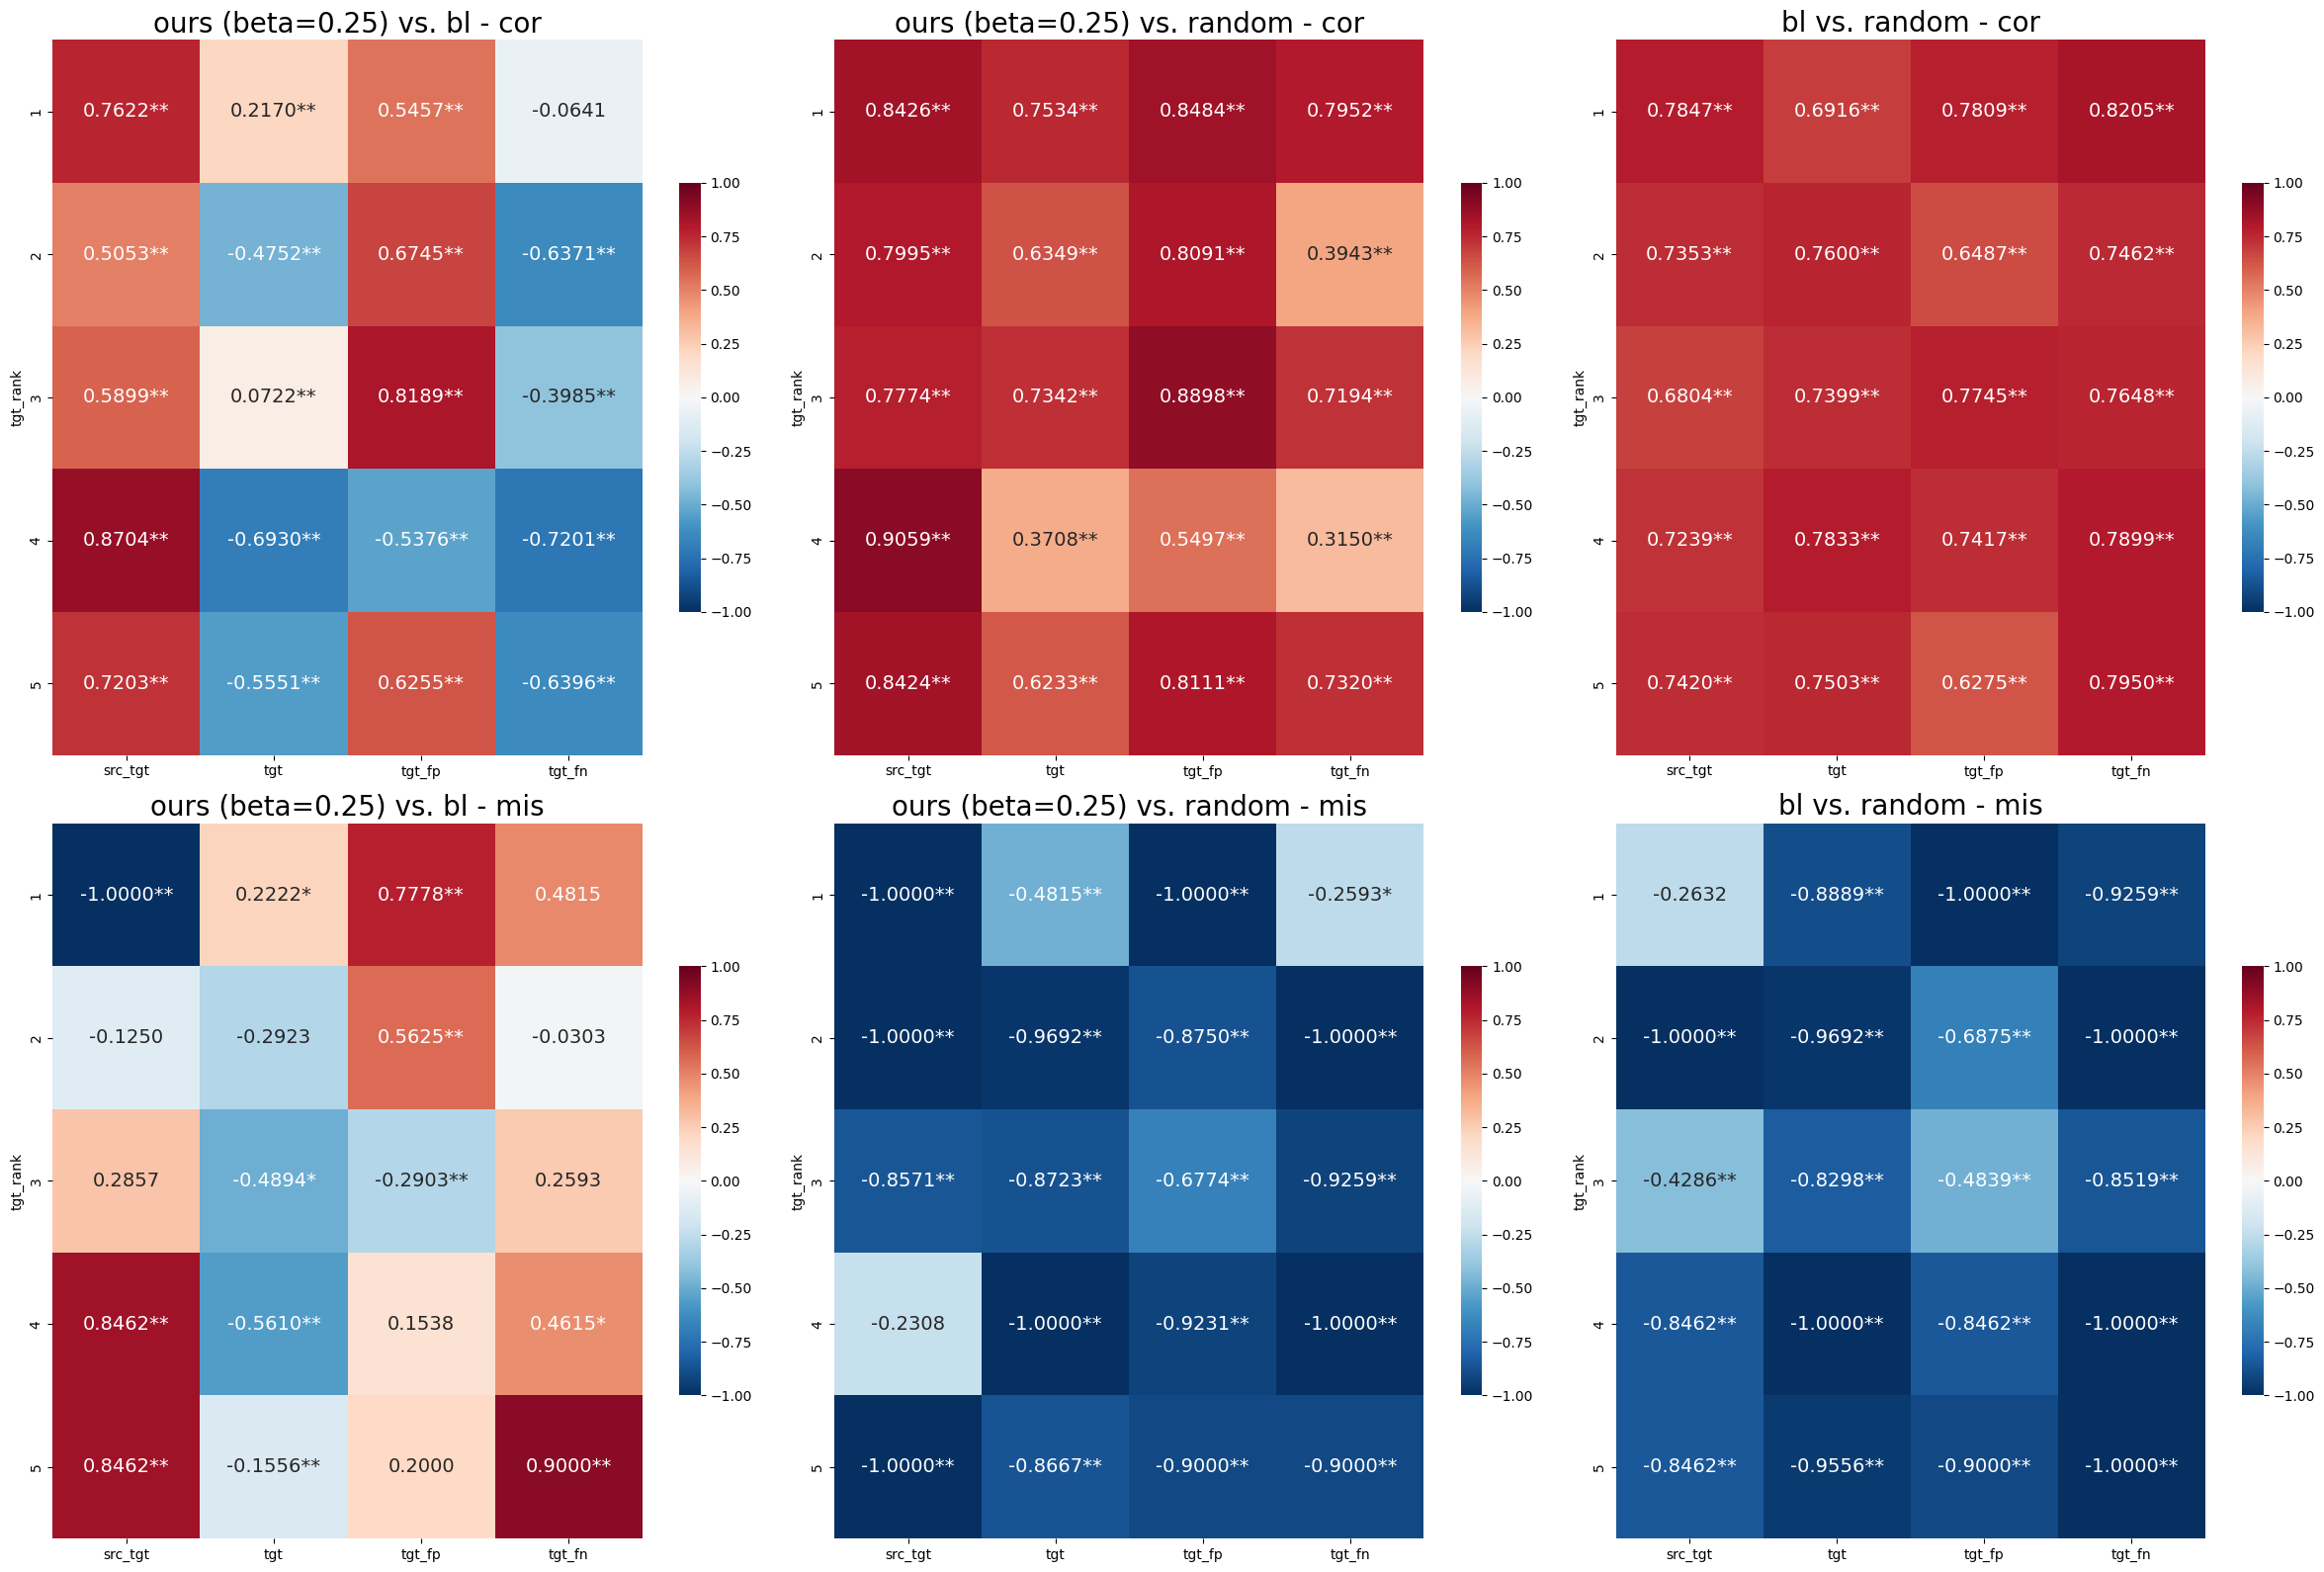

=== beta: 0.5 ===
Comparison pairs: [(('ours', 0.5), 'bl'), (('ours', 0.5), 'random'), ('bl', 'random')]


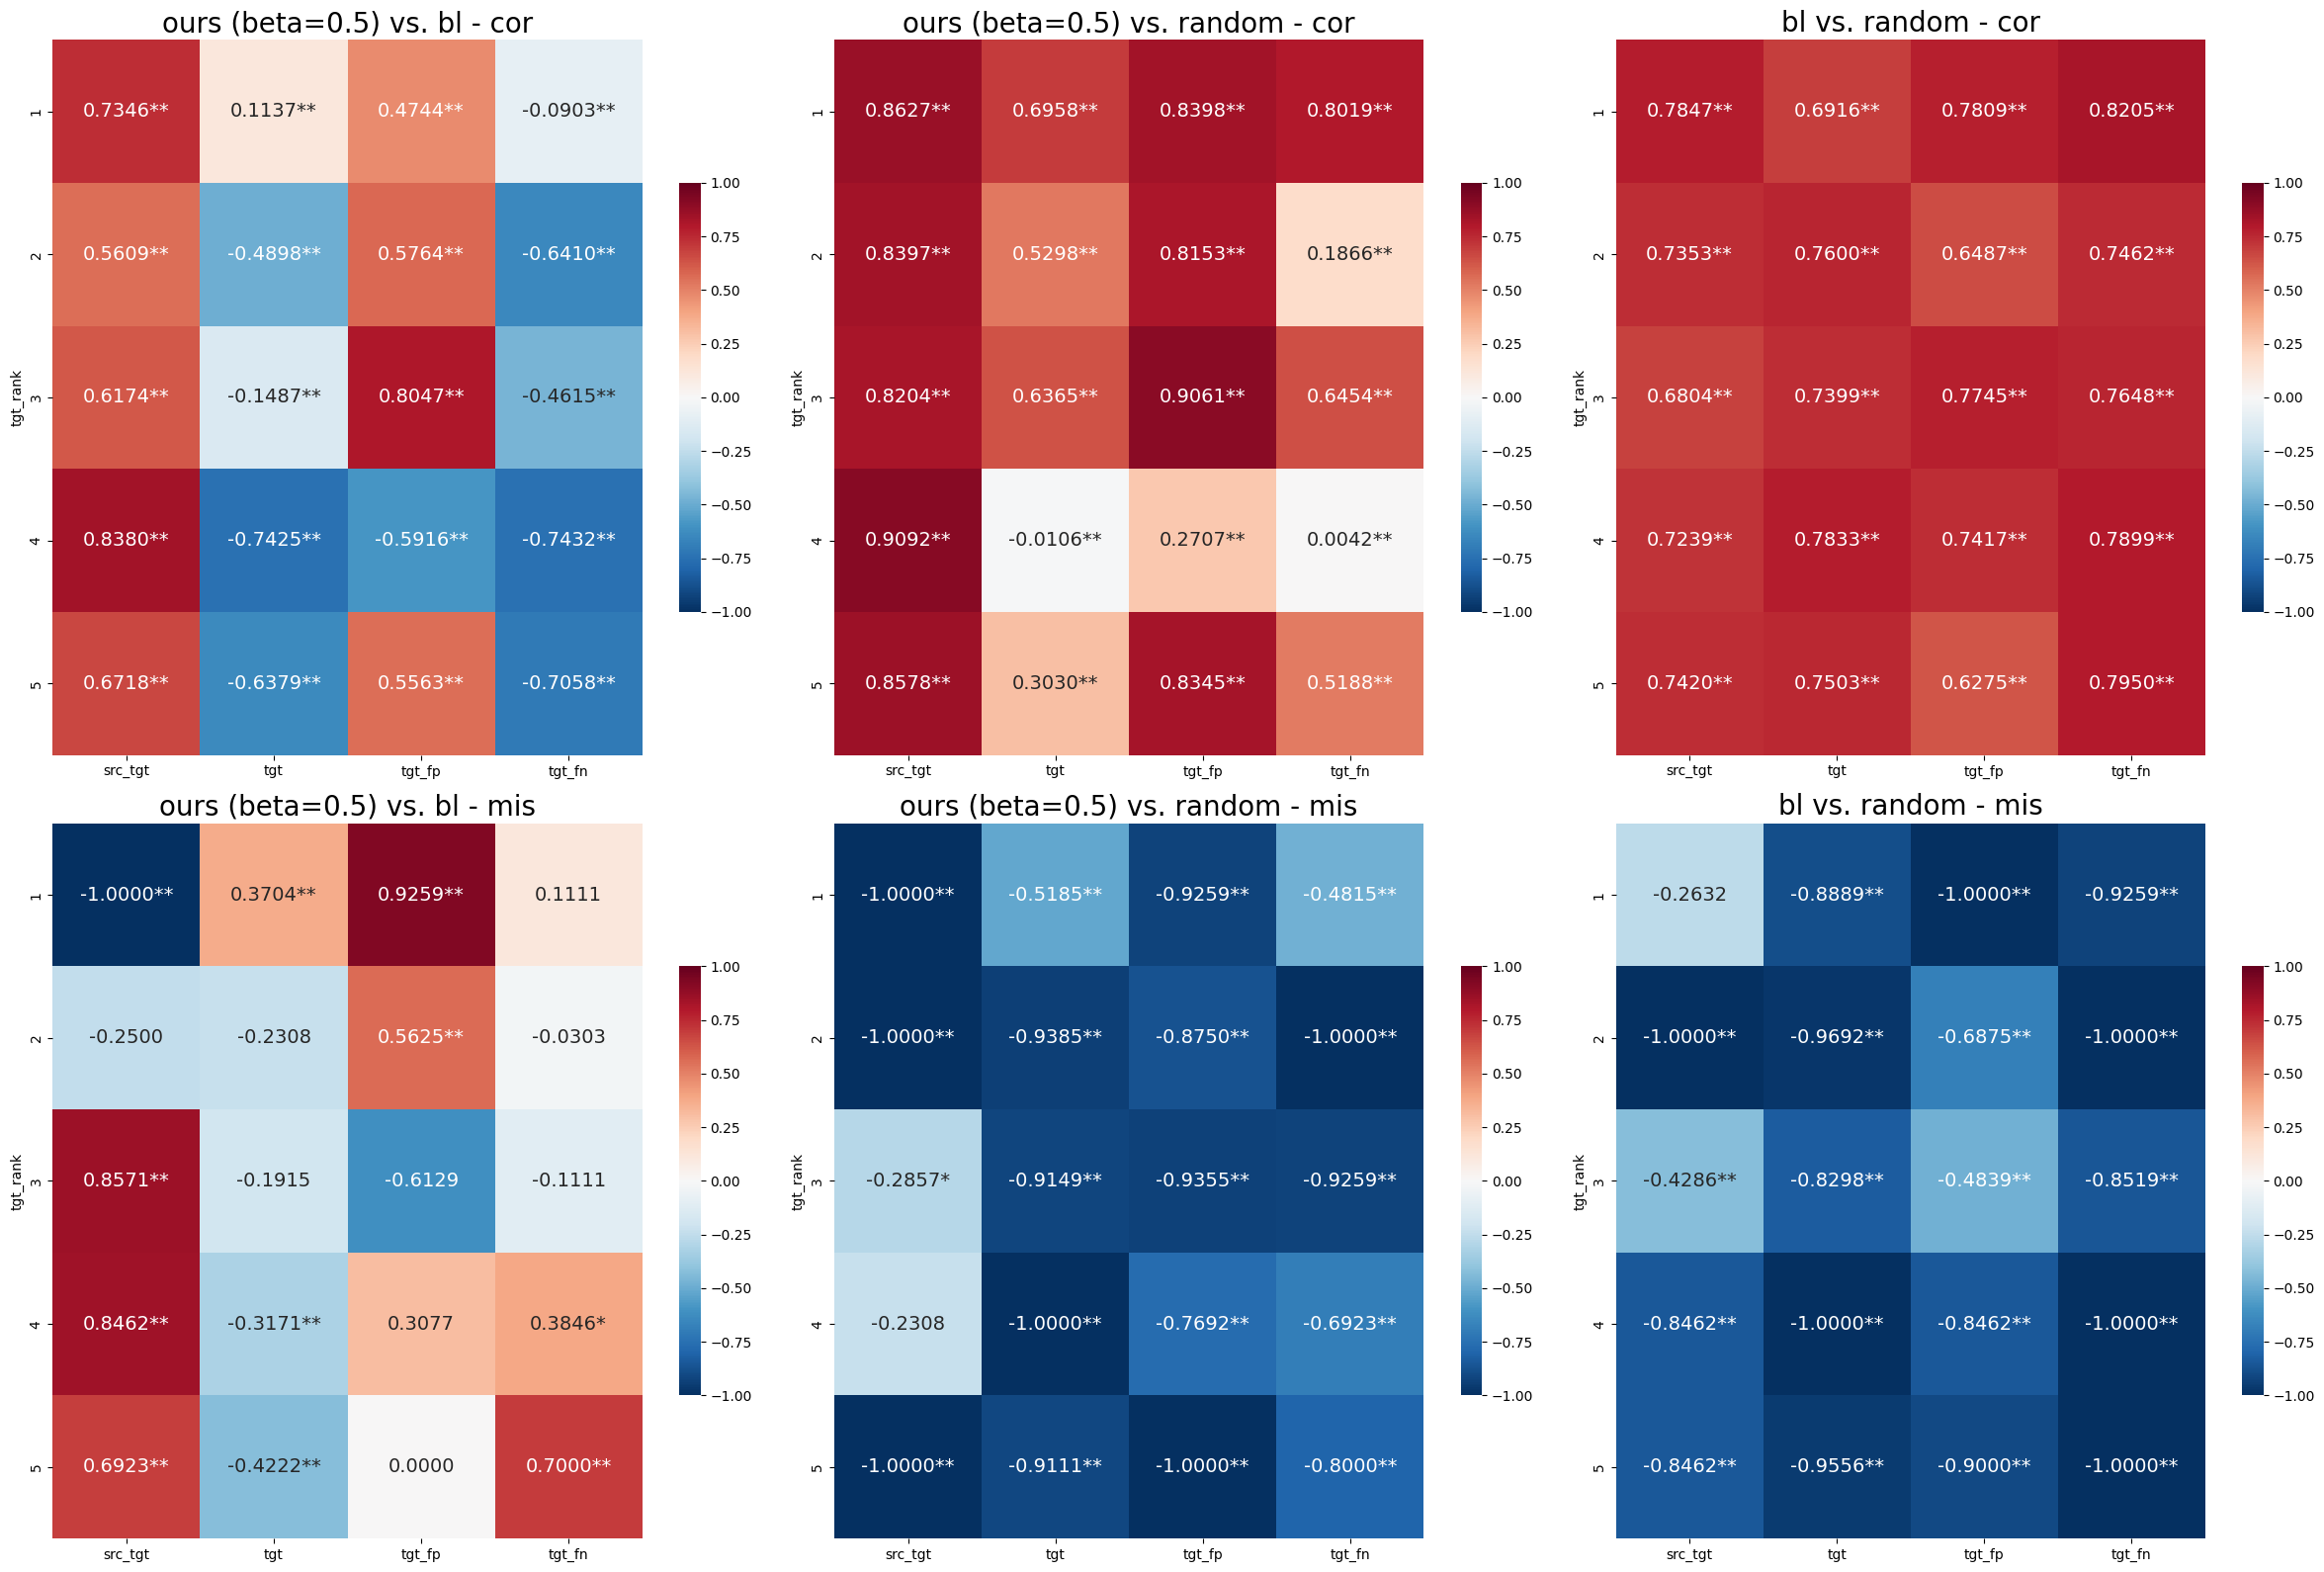

=== beta: 0.75 ===
Comparison pairs: [(('ours', 0.75), 'bl'), (('ours', 0.75), 'random'), ('bl', 'random')]


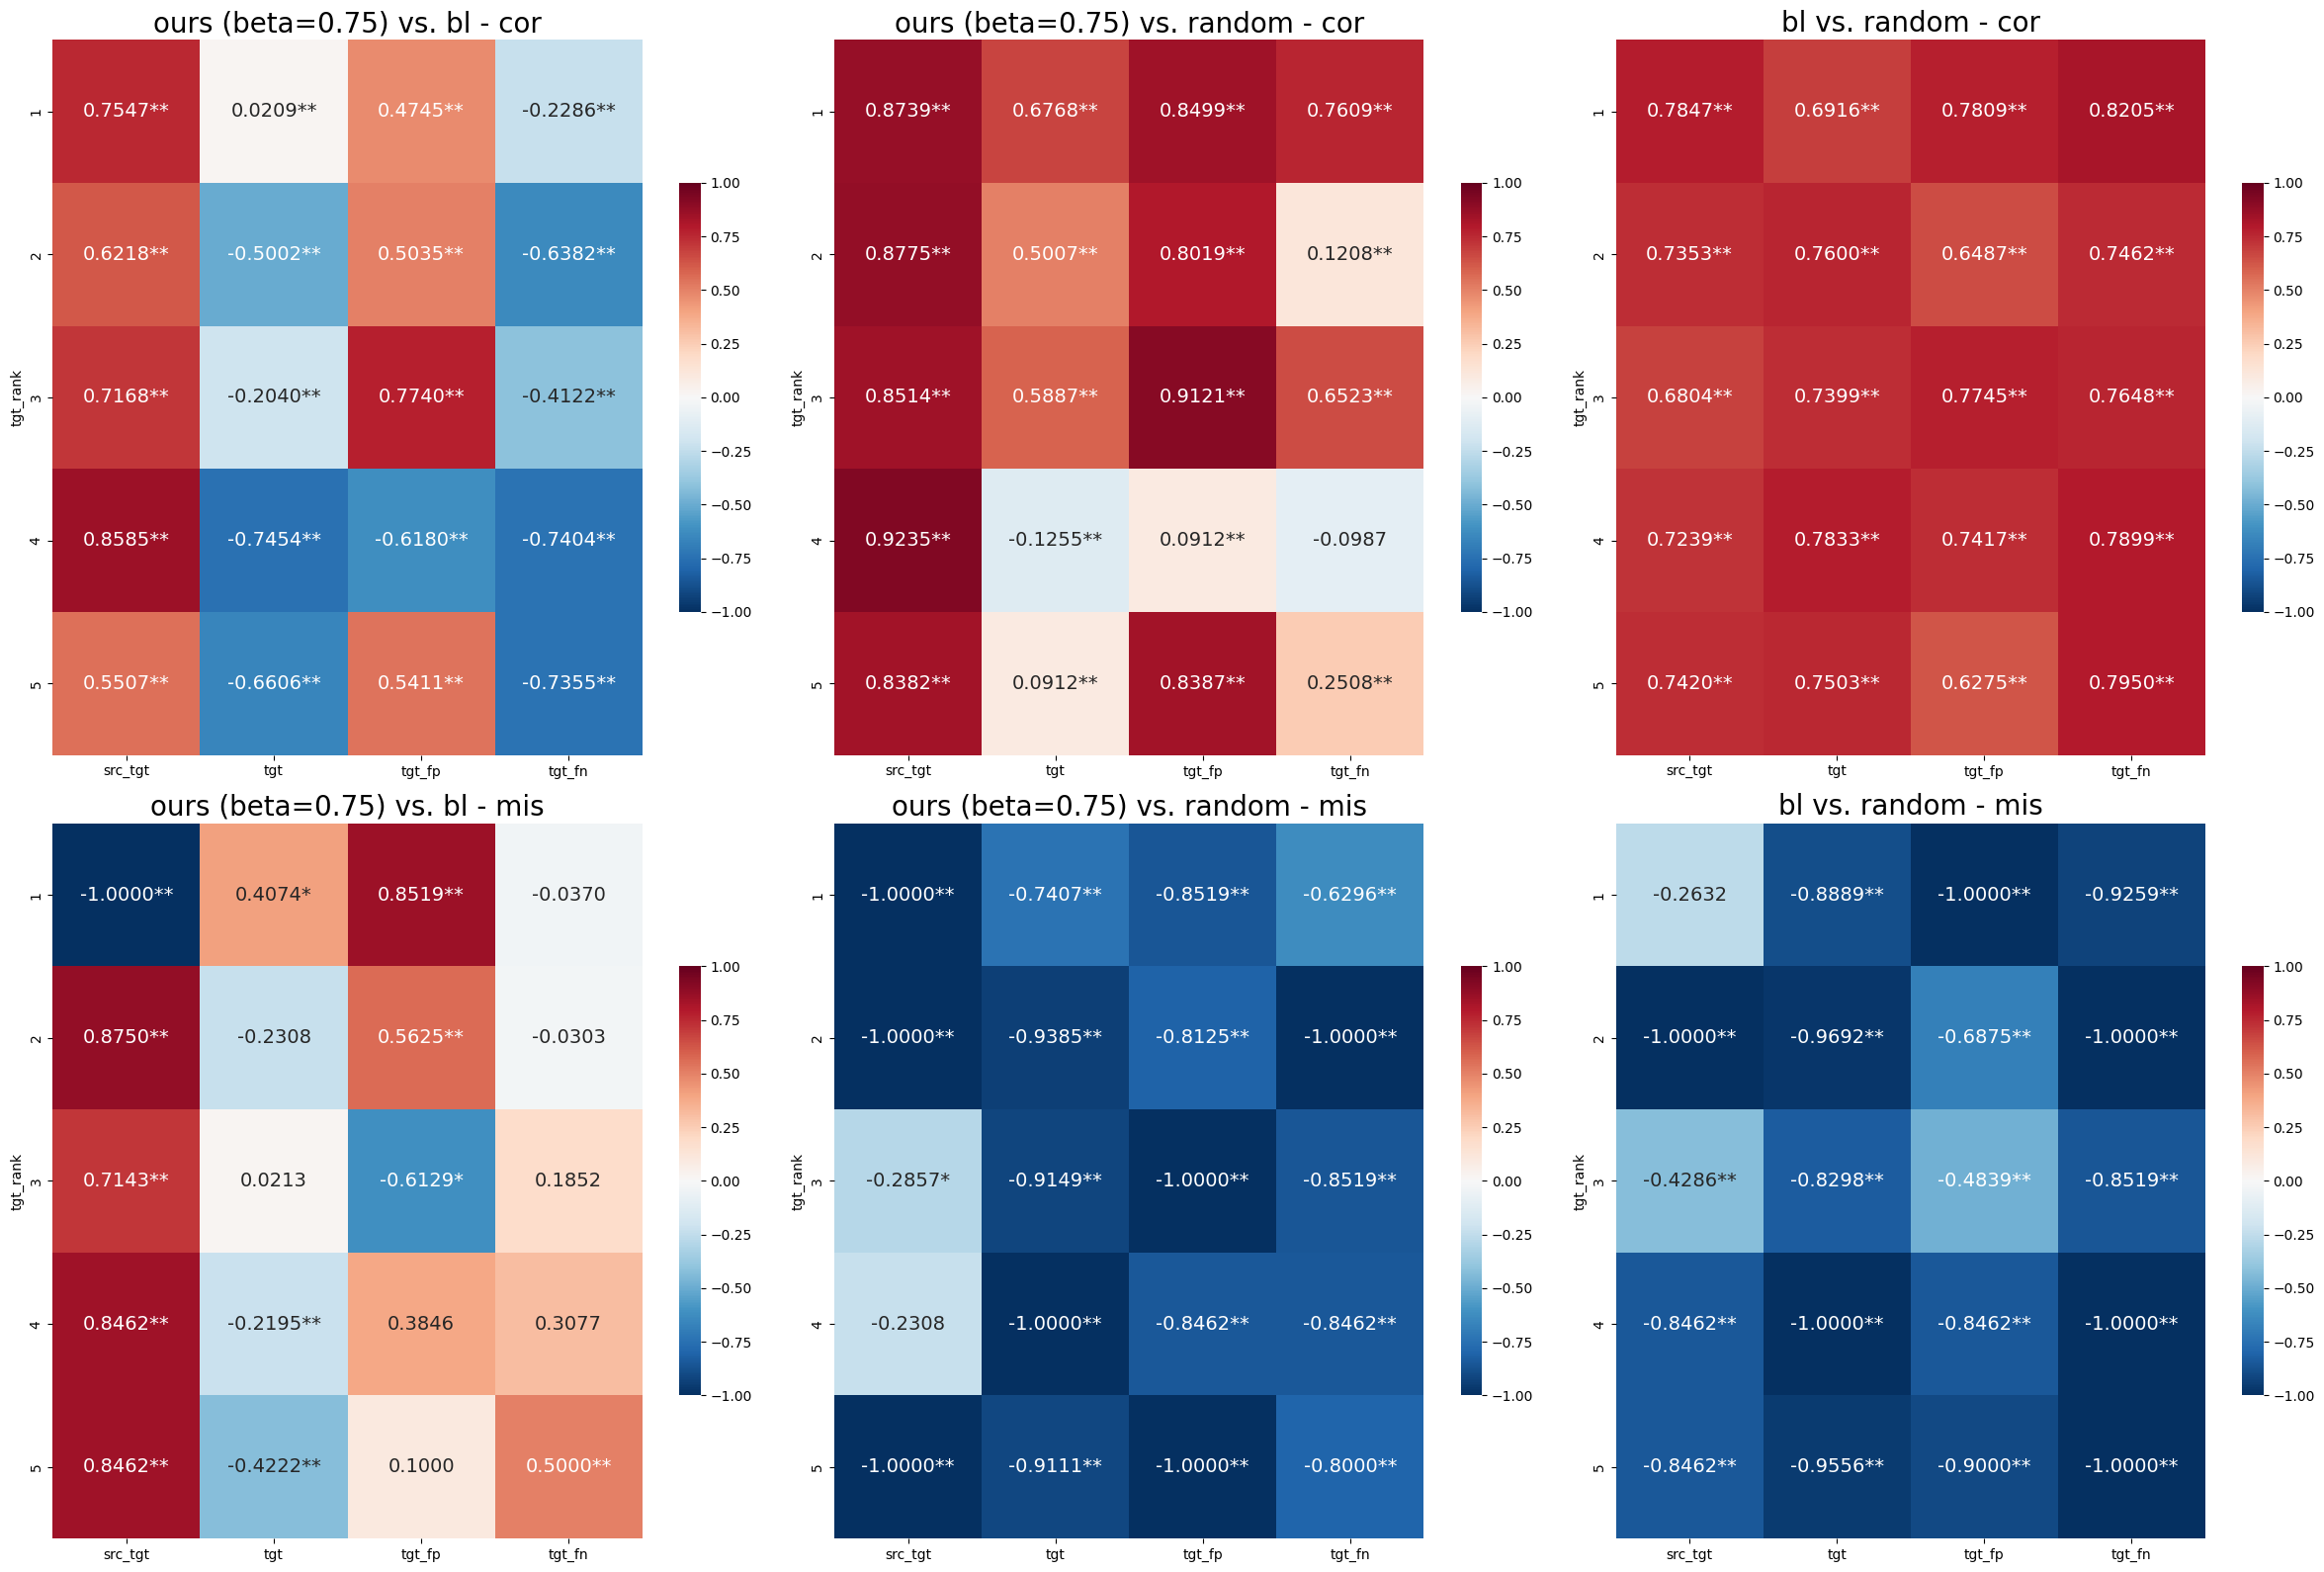

=== beta: 1.0 ===
Comparison pairs: [(('ours', 1.0), 'bl'), (('ours', 1.0), 'random'), ('bl', 'random')]


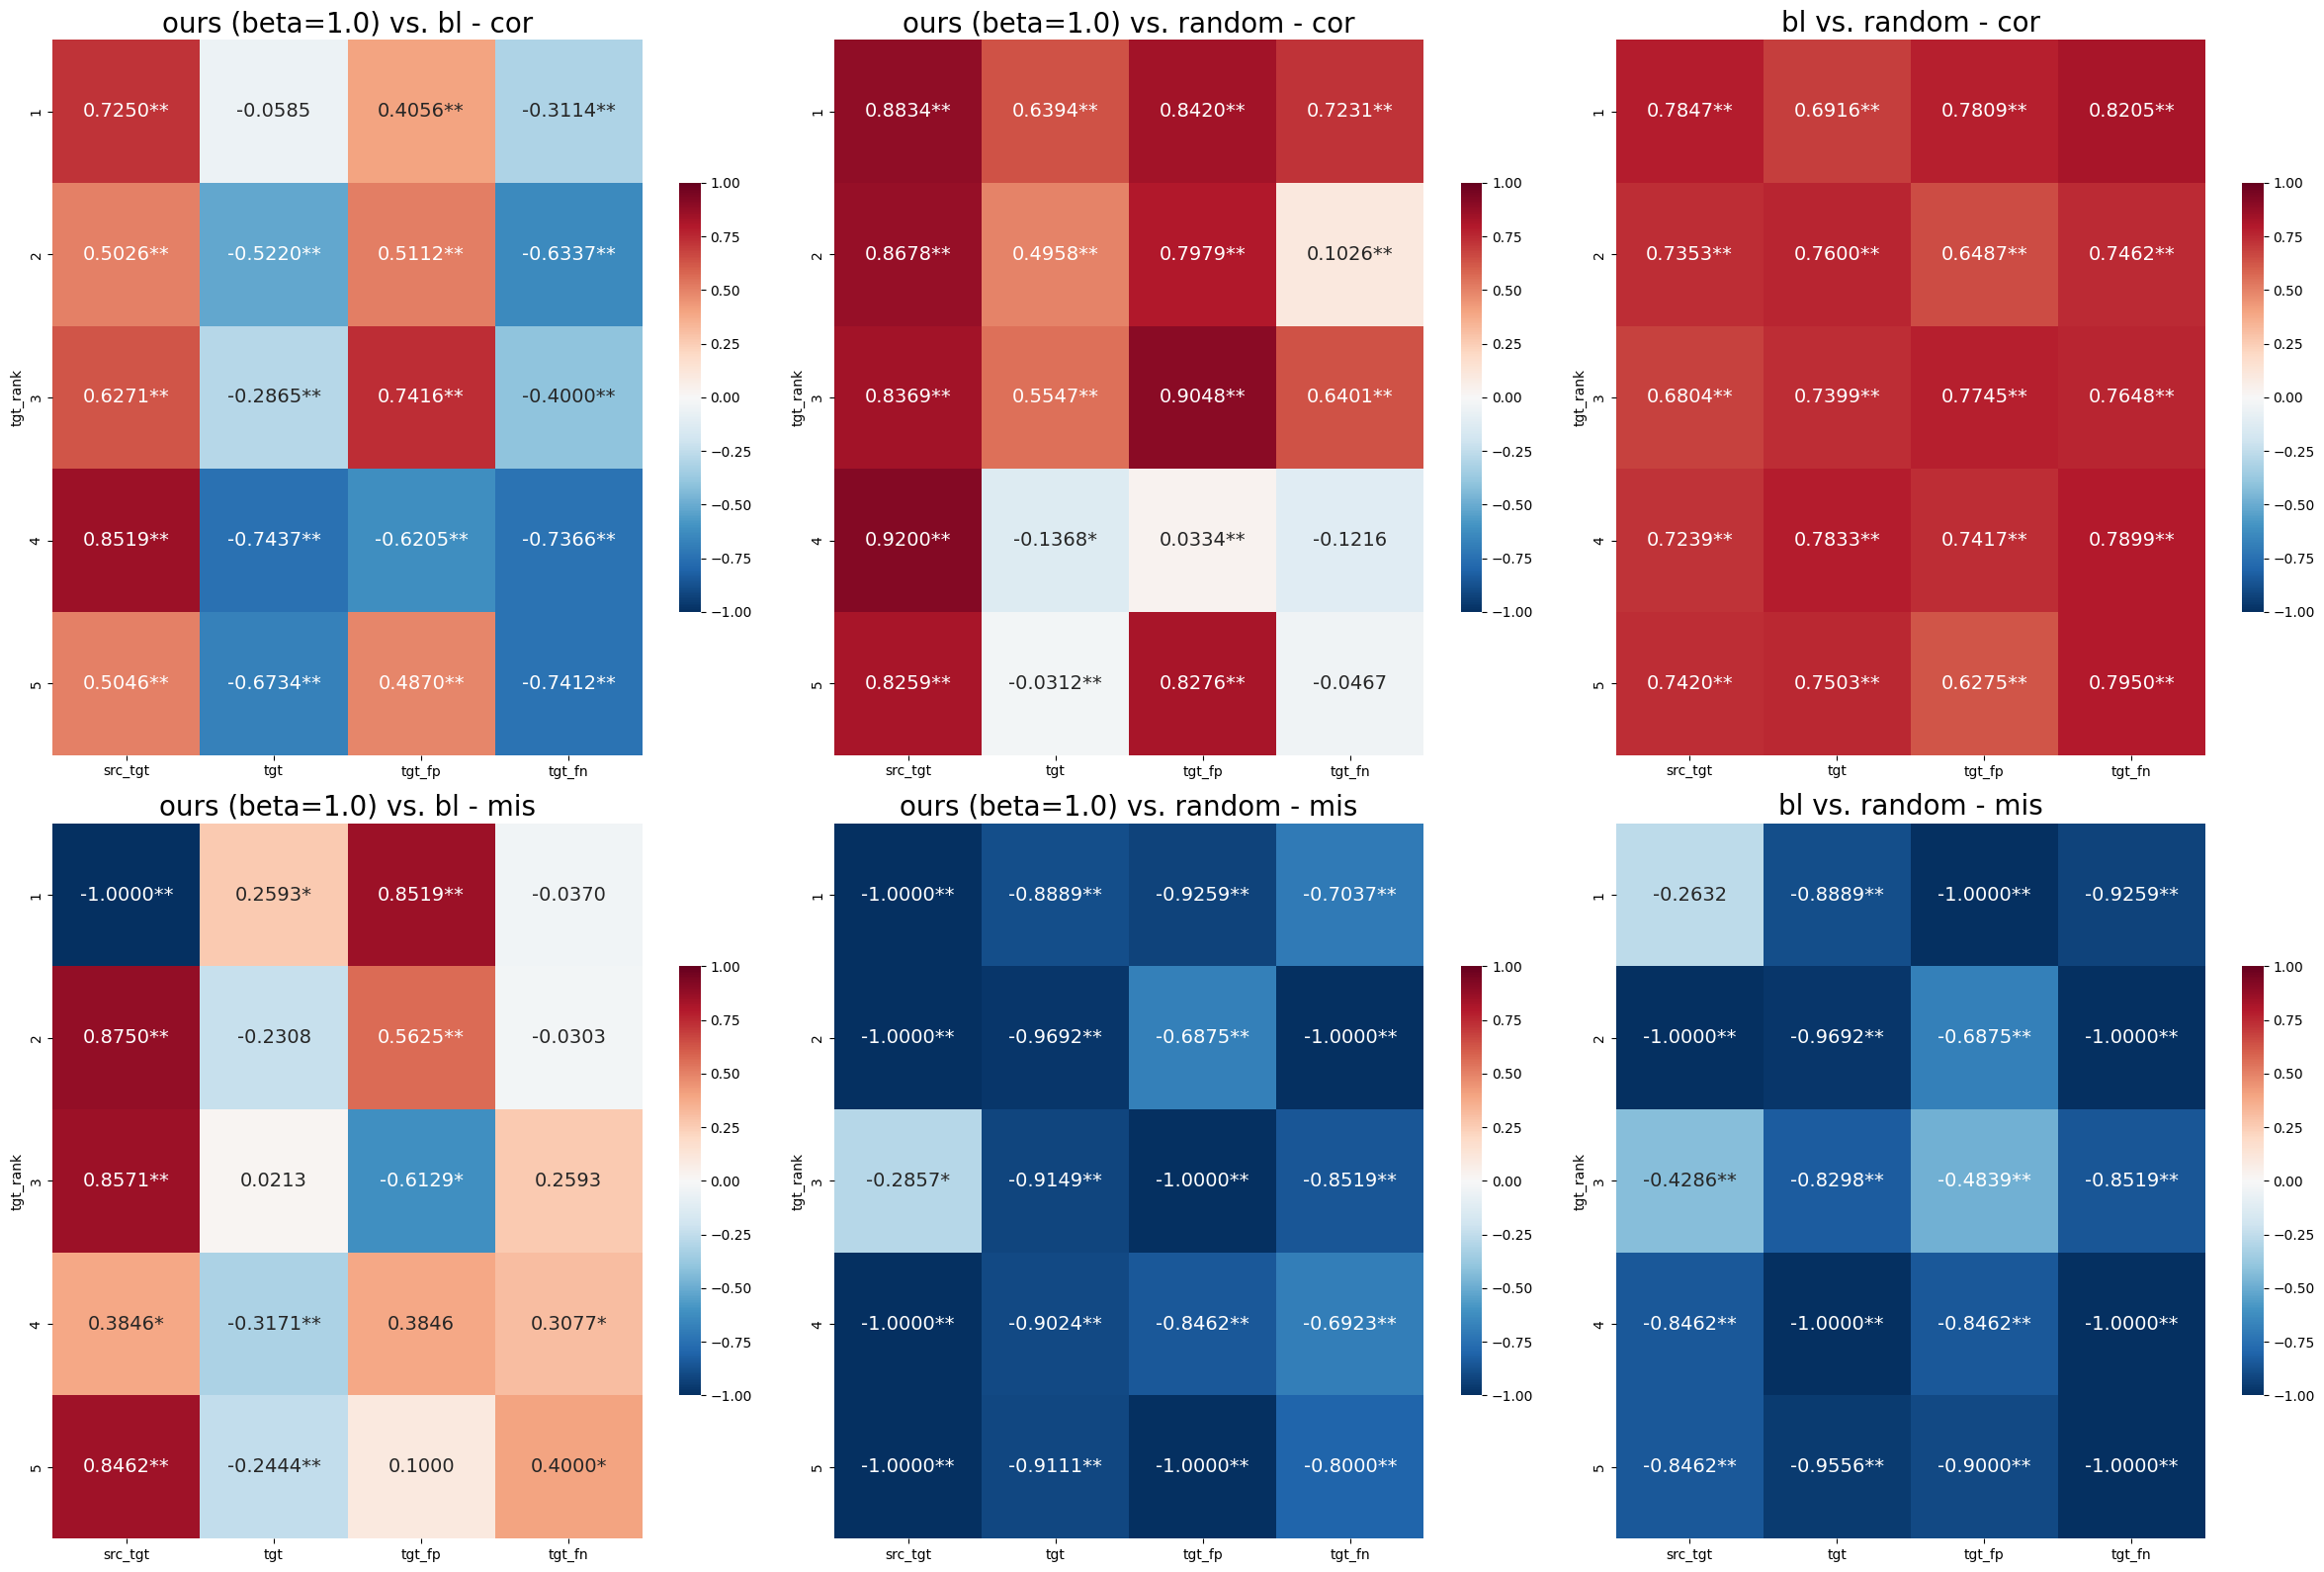

In [8]:
for beta, comp_pair in comparison_pairs.items():
    print(f"=== beta: {beta} ===")
    print(f"Comparison pairs: {comp_pair}")
    fig, axes = plt.subplots(nrows=2, ncols=len(comp_pair), figsize=(24, 16))

    cmap = "RdBu_r"
    for col_idx, (method_a, method_b) in enumerate(comp_pair):
        if isinstance(method_a, tuple):
            method_a, _ = method_a
        if isinstance(method_b, tuple):
            method_b, _ = method_b
        # print(f"Comparing {method_a} and {method_b} with beta={beta}")
        ax_dic = {"cor": axes[0, col_idx], "mis": axes[1, col_idx]}
        for sample_type in sample_types:
            data = np.zeros((len(tgt_ranks), len(misclf_types)))
            annot = np.empty((len(tgt_ranks), len(misclf_types)), dtype=object)
            for i, tgt_rank in enumerate(tgt_ranks):
                for j, misclf_type in enumerate(misclf_types):
                    # print(f"{method_a} vs {method_b} - tgt_rank: {tgt_rank}, misclf_type: {misclf_type}, sample_type: {sample_type}")
                    loss_a = load_best_loss_diff(n, beta, method_a, tgt_rank, misclf_type, sample_type, ops=op_list)
                    loss_b = load_best_loss_diff(n, beta, method_b, tgt_rank, misclf_type, sample_type, ops=op_list)
                    # print(f"misclf_type: {misclf_type}, sample_type: {sample_type}, tgt_rank: {tgt_rank}, method_a: {method_a}, method_b: {method_b}")
                    # print(f"loss_a.shape: {loss_a.shape}, loss_b.shape: {loss_b.shape}")
                    # 両方のFL手法のロスは同じ長さであることを確認 (同じサンプルに対してのスコアなので)
                    assert len(loss_a) == len(loss_b), f"Length mismatch: {len(loss_a)} vs {len(loss_b)}"
                    # 両方のFL手法のロスにnanがあってはいけない
                    assert not np.isnan(loss_a).any(), f"NaN found in {method_a} loss"
                    # 両者のロスのに対して検定を実行
                    stat, p = wilcoxon(loss_a, loss_b)
                    cliffs_delta = cliffs_delta_from_diff(loss_a - loss_b)
                    data[i, j] = cliffs_delta
                    # 有意性によるアノテーション
                    if p < 0.01:
                        annot[i, j] = f"{cliffs_delta:.4f}**"
                    elif p < 0.05:
                        annot[i, j] = f"{cliffs_delta:.4f}*"
                    else:
                        annot[i, j] = f"{cliffs_delta:.4f}"
            df_heat = pd.DataFrame(data, index=tgt_ranks, columns=misclf_types)
            sns.heatmap(df_heat, ax=ax_dic[sample_type], annot=annot, fmt="", cmap=cmap,
                        center=0, vmin=-1, vmax=1, cbar_kws={"shrink": 0.6}, annot_kws={"size": 14},)
            ax_dic[sample_type].set_title(f"{method_a} vs. {method_b} - {sample_type}", fontsize=20)
            if method_a == "ours":
                ax_dic[sample_type].set_title(f"ours (beta={beta}) vs. {method_b} - {sample_type}", fontsize=20)
            if method_b == "ours":
                ax_dic[sample_type].set_title(f"{method_b} vs. ours (beta={beta}) - {sample_type}", fontsize=20)
            # ax_dic[sample_type].set_title(f"Comparing {method_a} and {method_b} with beta={beta}")
            ax_dic[sample_type].set_xlabel("")
            ax_dic[sample_type].set_ylabel("tgt_rank")
    plt.tight_layout()
    plt.show()